# Part 1: Statistical and ML analysis of Dataset using Linear Regression







## Linear Regression from a statistical inference standpoint

Linear Models make some assumptions over the independent variables such as:
1. Linear Relationship between independent and target variables
2. Normal/Gaussian Distribution of the residuals of the model
3. Multicollinearity of independent variables (though this does not affect model predictions unless model overfits)
4. Homoscedasticity

We check whether these assumptions are being followed or not using:
1. Linearity using regplots and scatterplots
2. Normality of residuals using histograms
3. Multicollinearity using correlation matrices and VIF

### These assumptions need to be satisfied in order to make valid inferences from our regression, if they are not satisfied, it doesnt mean the model predictions are wrong.

If these assumptions are not met we might try to use some Mathematical transformations such as:
1. Log transformation
2. BoxCox transformation
3. Higher or lower power transformations
etc.


## Note on Machine Learning Standpoint 


1. Train test split is not a very reliable validation strategy for such less amounts of data. The test and train splits thus formed might not be representative of each other and give unknown fits such as test score being better than train score.


2. More features, transformations, feature engineering etc. might not give the desired results as the model will most probably not learn any significant relations from such less amount of data

## Importing Libraries

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library for regular expression matching operations
import re

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Train test split
from sklearn.model_selection import train_test_split

# Linear Regression Models and Logistic regression                           
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
                        
# Evaluation Metrics                       
from sklearn.metrics import mean_squared_error,accuracy_score
                        
# MinMaxScaler and StandardScaler                        
from sklearn import preprocessing
                        
# VIF to show Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor as v_i_f

## Data Loading, Cleaning and Exploration

In [2]:
df = pd.read_csv('IPL 2022 Batters.csv')

In [3]:
df.head()

,Player,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s
0,Jos Buttler,17,17,2,863,116,57.53,579,149.05,4,4,83
1,K L Rahul,15,15,3,616,103*,51.33,455,135.38,2,4,45
2,Quinton De Kock,15,15,1,508,140*,36.29,341,148.97,1,3,47
3,Hardik Pandya,15,15,4,487,87*,44.27,371,131.26,0,4,49
4,Shubman Gill,16,16,2,483,96,34.5,365,132.32,0,4,51


### Trying an Engineered Feature

In [4]:
# Batsmen would usually score more 4s and they would almost always get a change to bat hence, Mat-Inns 
# will be lesser for batsmen then bowlers
df['Not_Played'] = df['Mat'] - df['Inns']
df['Not_Played'] = np.where(df['Not_Played']>6,7,df['Not_Played'])

In [5]:
# "Most of the values are 0 so we are dropping the feature" was my initial though but didnot drop 
# because someone who can score a century in a T20 must be a hard hitter so might score more 4s
# df['100'].value_counts()
# df.drop('100',axis = 'columns',inplace = True)

In [6]:
# Here, we note that we have very less data and so there is a good chance of the model underfitting 
# and not learning important relation
df.shape

(162, 13)

In [7]:
# No Null Values found in data
df.isnull().sum()

Player        0
Mat           0
Inns          0
NO            0
Runs          0
HS            0
Avg           0
BF            0
SR            0
100           0
50            0
4s            0
Not_Played    0
dtype: int64

In [8]:
# Some features have unexpected datatypes so we explore this further  
df.dtypes

Player         object
Mat             int64
Inns            int64
NO              int64
Runs            int64
HS             object
Avg            object
BF              int64
SR            float64
100             int64
50              int64
4s              int64
Not_Played      int64
dtype: object

In [9]:
# Here we note that for cases of Highest Score when the batsman was not out, there is an asterix (*) next to the score 
# which needs to be removed 
df['HS']

0       116
1      103*
2      140*
3       87*
4        96
       ... 
157      2*
158       2
159      1*
160      1*
161      1*
Name: HS, Length: 162, dtype: object

In [10]:
# Removing the asterix and converting feature to float datatype
def remove(i):
    i = re.sub('\W','',i)
    return i
df['HS'] = df['HS'].apply(remove).astype('float64')

In [11]:
# The 'Avg' feature was of object type and it had hyphen as one of the entries whuch on further analysis 
# indicated that it refers to 0 as Number of Innings and Not outs were same (Average = Runs/(Inns-NO))
df.drop(df[df['Avg'] == '-'].index,axis = 'index',inplace = True)
df['Avg'] = df['Avg'].astype('float64')

In [12]:
# Now we note that the dataypes are how they are supposed to be
df.dtypes

Player         object
Mat             int64
Inns            int64
NO              int64
Runs            int64
HS            float64
Avg           float64
BF              int64
SR            float64
100             int64
50              int64
4s              int64
Not_Played      int64
dtype: object

In [13]:
# Dropping Player Column as It wont be of any use in Regression
df = df.drop('Player',axis = 'columns')

## Univariate Analysis

In [14]:
# Assigning columns to different categories
numerical_cols = ['Runs','HS','Avg','BF','SR']
categorical_cols = ['NO','50','Mat','Inns','Not_Played']
target = '4s'

### Categorical Features 


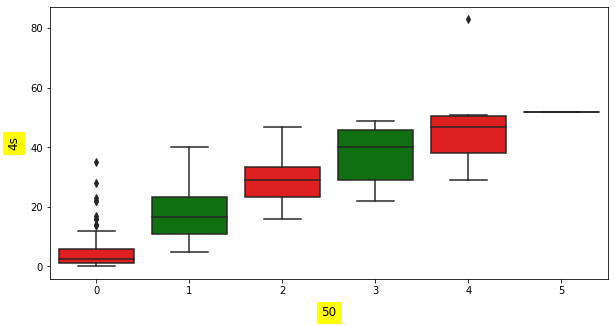

In [15]:
# More the number of 50s, the more heavy hitter the batsman is and hance more 4s 
plt.figure(figsize = (10,5))
ax1 = plt.subplot(111)
sns.boxplot(df['50'],df['4s'],palette=['red','green'])
ax1.set_xlabel('50' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax1.set_ylabel('4s' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.show()

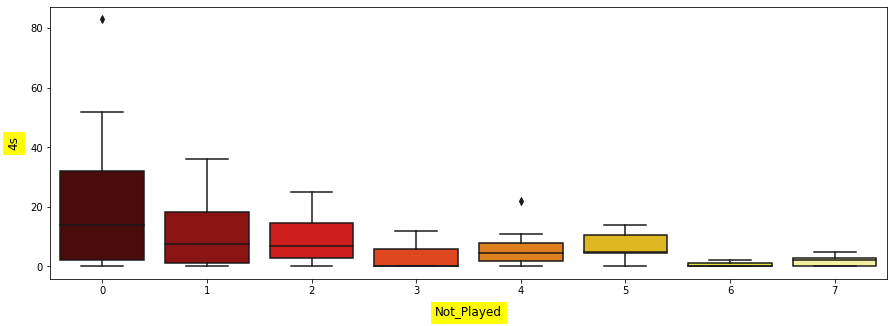

In [16]:
plt.figure(figsize = (15,5))
ax1 = plt.subplot(111)
sns.boxplot(df['Not_Played'],df['4s'],palette= 'hot')
ax1.set_xlabel('Not_Played' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax1.set_ylabel('4s' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.show()

### Numerical Features

Checking the Numerical Distribution and Checking for outliers. Outliers affect Linear Regression Model

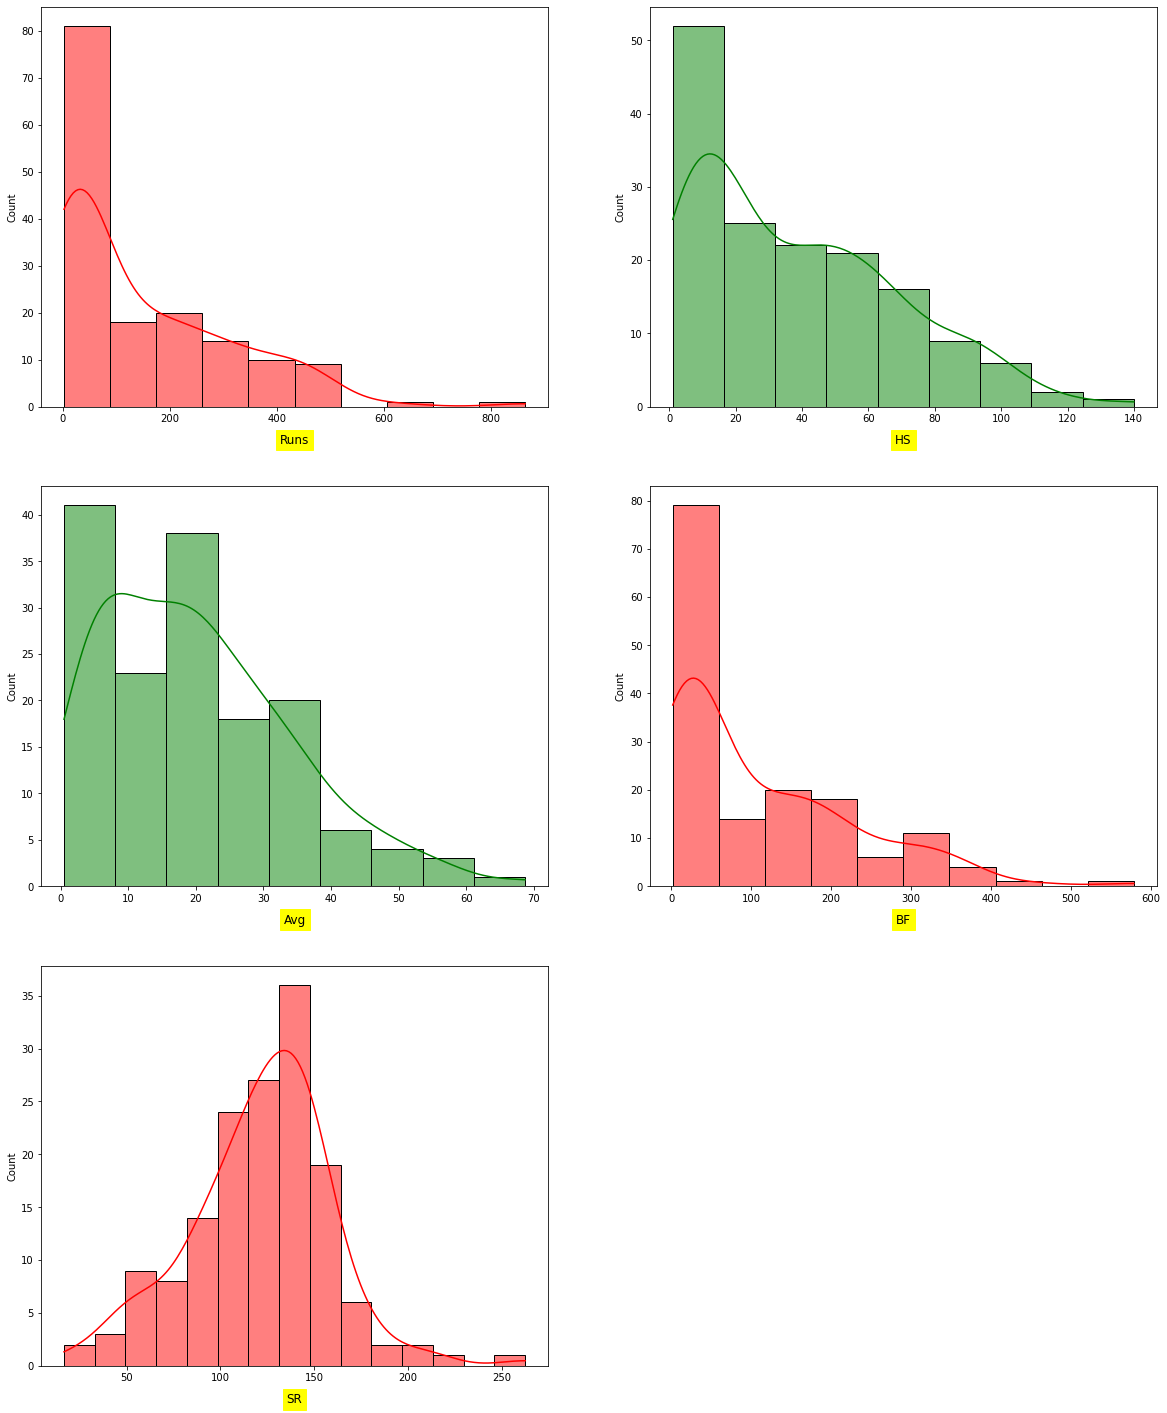

In [17]:
def plot_hist(feature,number,color):
    ax = plt.subplot(3,2,number)
    sns.histplot(df[feature],color = color,kde = True)
    ax.set_xlabel(feature ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)

plt.figure(figsize=(20,25))
plot_hist('Runs',1,'red')
plot_hist('HS',2,'green')
plot_hist('Avg',3,'green')
plot_hist('BF',4,'red')
plot_hist('SR',5,'red')

## Bivariate Analysis

Analyzing interaction of features in pairs

### Pairplot between Numerical Features

<Figure size 1800x1800 with 0 Axes>

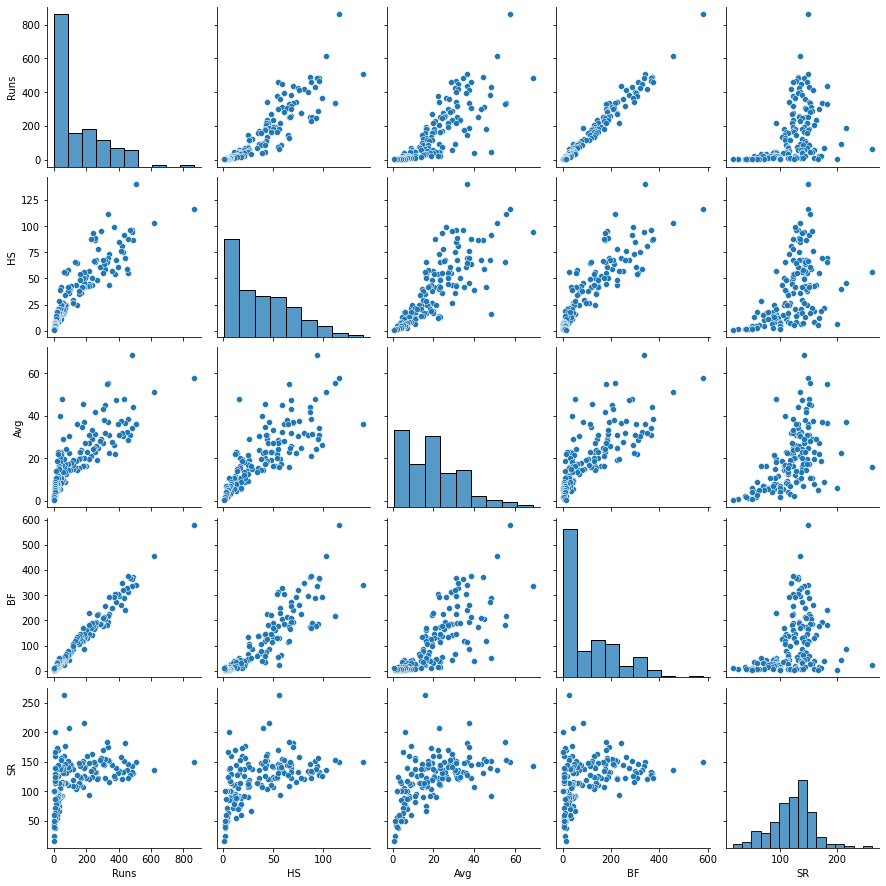

In [18]:
plt.figure(figsize = (25,25))
sns.pairplot(df[numerical_cols])

### Checking Linearity Relationship with Target Variable + Scatter Plots with Target 

Important both from a statistical and ML standpoint

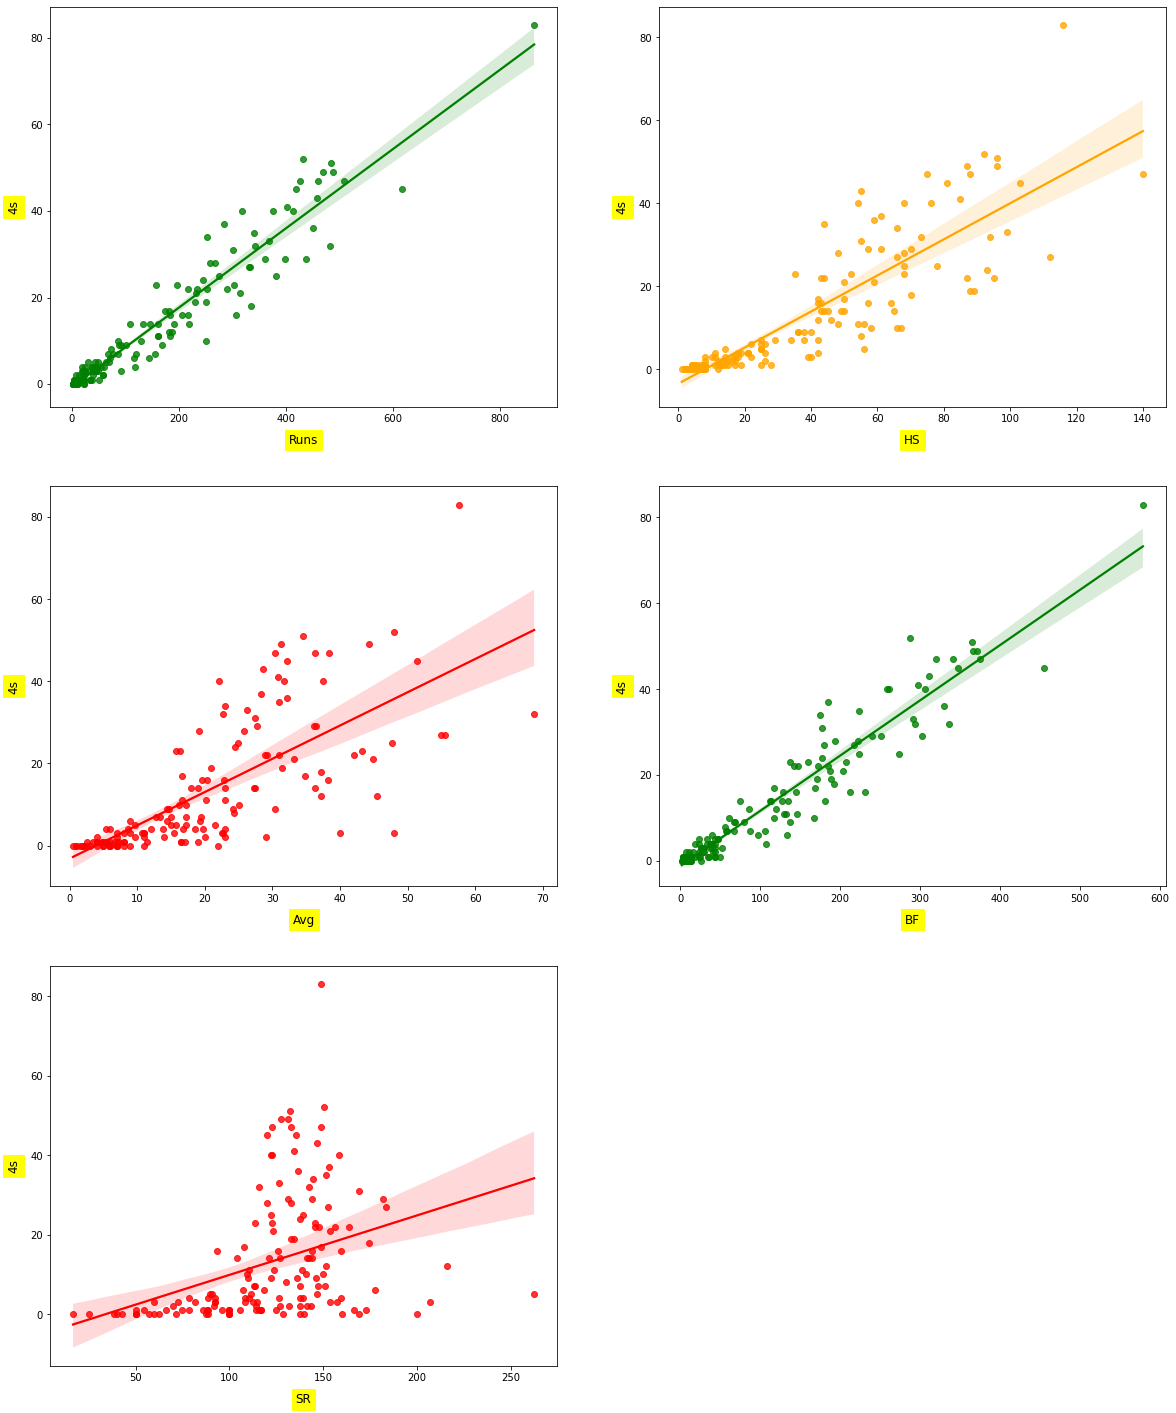

In [19]:
# Regplots are scatterplots with a linear regression line
plt.figure(figsize=(20,25))
def plot_reg(feature,number,color):
    ax = plt.subplot(3,2,number)
    sns.regplot(x = feature, y = '4s', data = df,order = 1,color = color,scatter = True, fit_reg = True)
    ax.set_xlabel(feature ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
    ax.set_ylabel('4s' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plot_reg('Runs',1,'green')
plot_reg('HS',2,'orange')
plot_reg('Avg',3,'red')
plot_reg('BF',4,'green')
plot_reg('SR',5,'red')

In [20]:
# plt.figure(figsize=(20,25))
# def plot_reg(feature,number,color):
#     ax = plt.subplot(3,2,number)
#     sns.scatterplot(x = feature, y = '4s', data = df,color = color)
#     ax.set_xlabel(feature ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
#     ax.set_ylabel('4s' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
# plot_reg('Runs',1,'green')
# plot_reg('HS',2,'orange')
# plot_reg('Avg',3,'red')
# plot_reg('BF',4,'green')
# plot_reg('SR',5,'red')

### Correlation of features with target variable

In continuation with the information gathered from the regplots

In [21]:
lst = []
for i in df.columns:
    lst.append(df[i].corr(df['4s']))
corr = pd.DataFrame()
corr['Feature'] = df.columns
corr['Corr'] = lst
corr = corr.drop(9,axis = 'index').reset_index(drop = True)
corr = corr.sort_values(by = 'Corr').reset_index(drop = True)
corr.style.background_gradient(cmap="coolwarm")

,Feature,Corr
0,Not_Played,-0.390265
1,NO,0.131417
2,SR,0.363906
3,100,0.440496
4,Mat,0.569934
5,Avg,0.728610
6,Inns,0.827892
7,HS,0.859767
8,BF,0.959259
9,Runs,0.962139


### Correlation Heatmap

<AxesSubplot:>

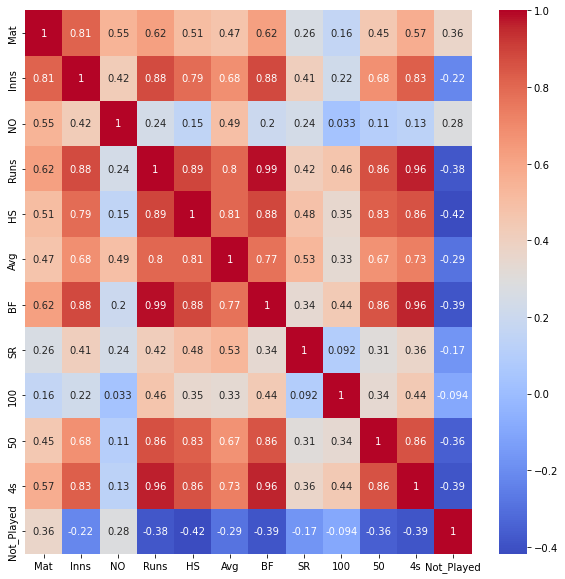

In [22]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(),cmap = 'coolwarm', annot = True)

### Normality of Residuals (Statistical)

For the Linear Model assumptions to be satisfied the residuals should have a normal distribution

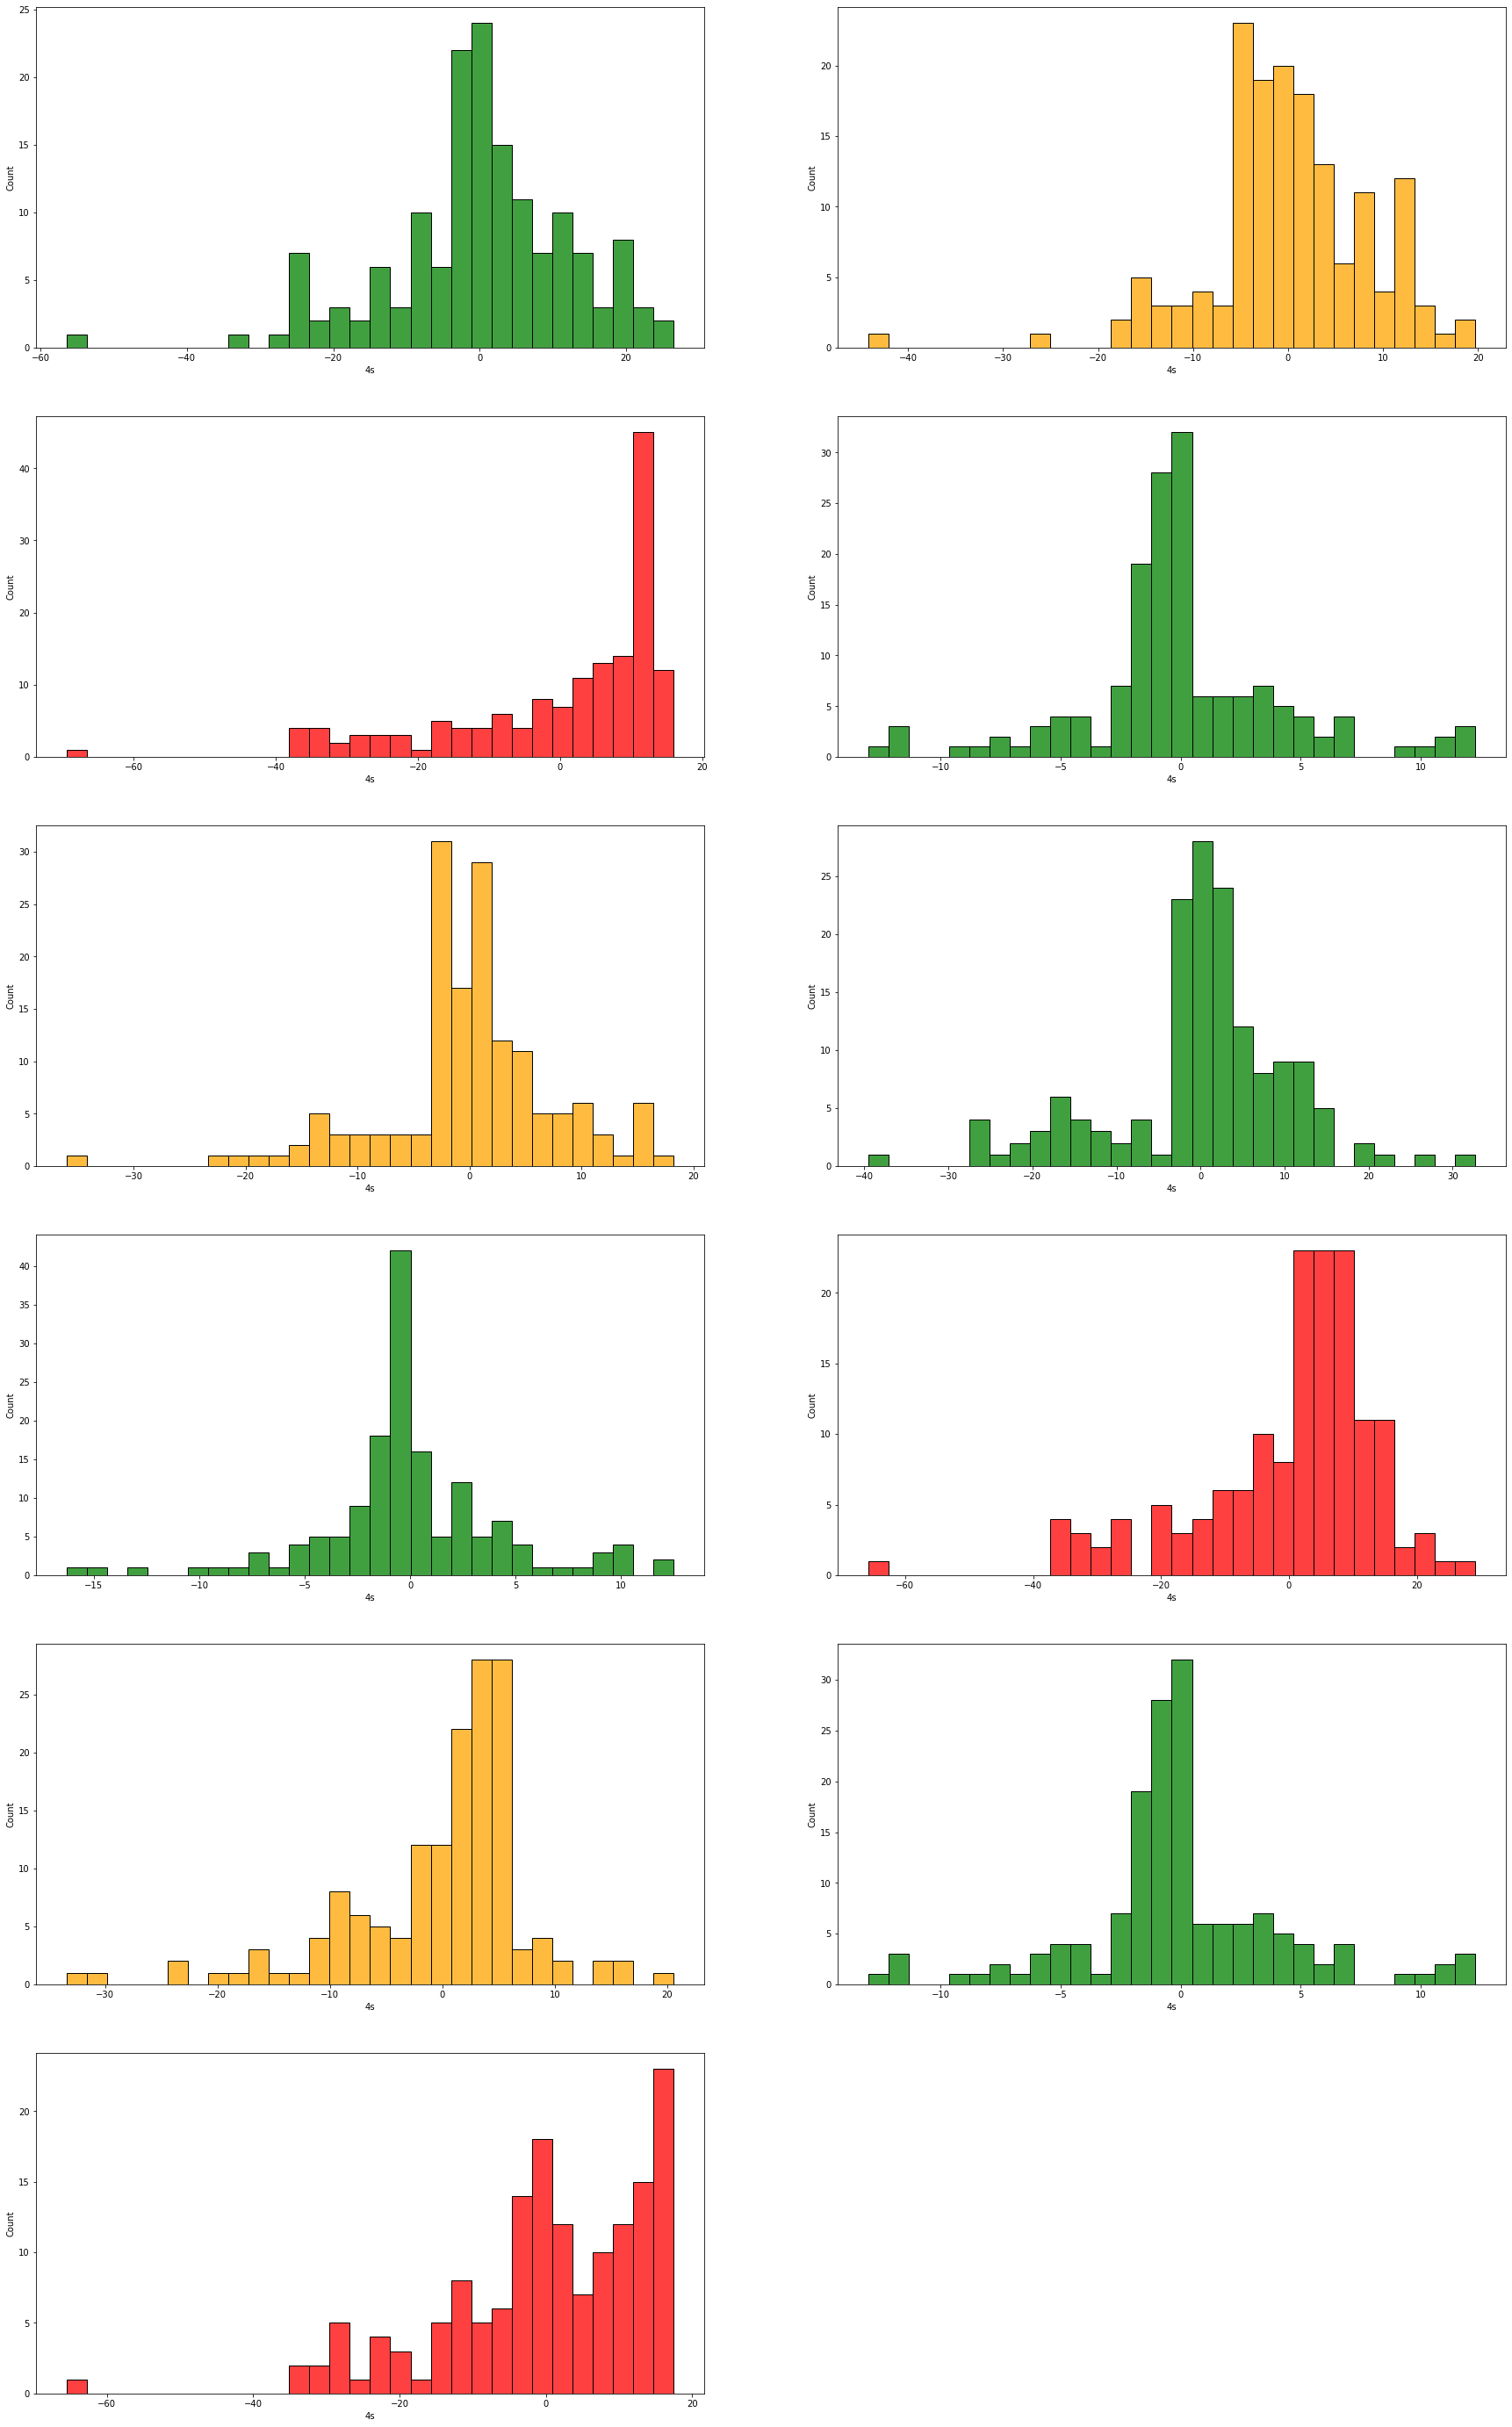

In [23]:
def plot_qq(feature,number,color):
    model = LinearRegression()
    model.fit(df[[feature]],df['4s'])
    preds = model.predict(df[[feature]])

    residuals = preds - df['4s']
    ax = plt.subplot(6,2,number)
    sns.histplot(residuals,color = color,bins = 30)

plt.figure(figsize = (30,50))
plot_qq('Mat',1,'green')
plot_qq('Inns',2,'orange')
plot_qq('NO',3,'red')
plot_qq('Runs',4,'green')
plot_qq('HS',5,'orange')
plot_qq('Avg',6,'green')
plot_qq('BF',7,'green')
plot_qq('SR',8,'red')
plot_qq('50',9,'orange')
plot_qq('Runs',10,'green')
plot_qq('Not_Played',11,'red')

### Showing High Multicollinearity in the data (Statistical)

In [24]:
vif = pd.DataFrame()
X = df
vif['variables'] = X.columns
vif['VIF'] = [v_i_f(X.values,i) for i in range(X.shape[1])]
vif.style.background_gradient(cmap="hot")

,variables,VIF
0,Mat,157.317634
1,Inns,145.028169
2,NO,7.631109
3,Runs,116.455513
4,HS,22.699098
5,Avg,28.723924
6,BF,111.809981
7,SR,12.533420
8,100,2.114324
9,50,8.433844


## Model Training 

In [25]:
# Creating 2 dataframes for features and target
y = df['4s']
x = df[['Runs','HS','BF','50','Avg','Inns','Not_Played','100','SR']]

# One hot encoding
d = pd.get_dummies(x['50'],drop_first= True)
d.columns = ['50' + str(i) for i in range(len(df['50'].value_counts())-1)]
x = pd.concat([x.drop('50',axis = 'columns'),d],axis = 'columns')
d = pd.get_dummies(x['100'],drop_first= True)
d.columns = ['100' + str(i) for i in range(len(df['100'].value_counts())-1)]
x = pd.concat([x.drop('100',axis = 'columns'),d],axis = 'columns')

In [26]:
# Train test split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state = 572,train_size=0.8) #968

relevant_cols = [c for c in x.columns]

# Used MinMaxScaler because different features have different scales and not StandardScaler because featurees are not gaussian
scaler = preprocessing.MinMaxScaler() 
xtrain[relevant_cols] = scaler.fit_transform(xtrain[relevant_cols])
xtest[relevant_cols] = scaler.transform(xtest[relevant_cols])

model = LinearRegression()
result = model.fit(xtrain,ytrain)
preds = model.predict(xtest)
print('Test MSE:',mean_squared_error(ytest,preds))
preds_train = model.predict(xtrain)
print('Train MSE: ',mean_squared_error(ytrain,preds_train))

Test MSE: 6.950930793947837
Train MSE:  13.877755622949882


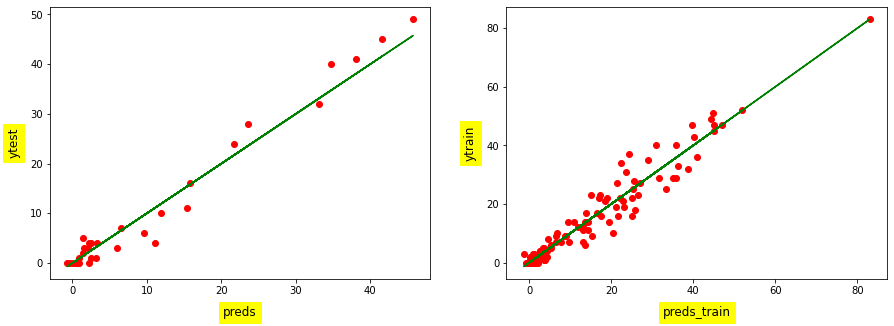

In [27]:
plt.figure(figsize = (15,5))
ax1 = plt.subplot(121)
ax1.set_xlabel('preds' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax1.set_ylabel('ytest' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.scatter(preds, ytest,color='r')
plt.plot(preds, model.predict(xtest),color='g')
ax2 = plt.subplot(122)
ax2.set_xlabel('preds_train' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax2.set_ylabel('ytrain' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.scatter(preds_train, ytrain,color='r')
plt.plot(preds_train, model.predict(xtrain),color='g')
plt.show()

In [28]:
lst = []
for i in range(model.coef_.shape[0]):
    lst.append(model.coef_[i])
corr = pd.DataFrame()
corr['Feature'] = x.columns
corr['Coef'] = lst
corr = corr.drop(9,axis = 'index').reset_index(drop = True)
corr = corr.sort_values(by = 'Coef').reset_index(drop = True)
corr.style.background_gradient(cmap="gnuplot")

,Feature,Coef
0,1001,-11.538511
1,Avg,-9.176872
2,Inns,-4.598568
3,500,-1.357844
4,503,-0.909498
5,501,-0.657231
6,1000,-0.476273
7,Not_Played,-0.429127
8,HS,2.976379
9,SR,3.401046


## Showing Effect of Changing Random State

In [29]:
# Random State changed to 986
# Train Test Split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state = 986,train_size=0.8) 

relevant_cols = [c for c in x.columns]

# Used MinMaxScaler because different features have different scales and not StandardScaler because featurees are not gaussian
scaler = preprocessing.MinMaxScaler()
xtrain[relevant_cols] = scaler.fit_transform(xtrain[relevant_cols])
xtest[relevant_cols] = scaler.transform(xtest[relevant_cols])

model = LinearRegression()
result = model.fit(xtrain,ytrain)
preds = model.predict(xtest)
print('Test MSE:',mean_squared_error(ytest,preds))
preds_train = model.predict(xtrain)
print('Train MSE: ',mean_squared_error(ytrain,preds_train))

Test MSE: 12.52447607661295
Train MSE:  12.500384852505446


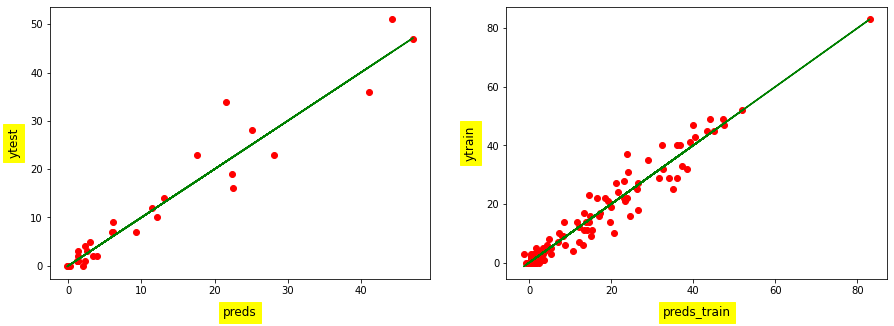

In [30]:
plt.figure(figsize = (15,5))
ax1 = plt.subplot(121)
ax1.set_xlabel('preds' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax1.set_ylabel('ytest' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.scatter(preds, ytest,color='r')
plt.plot(preds, model.predict(xtest),color='g')
ax2 = plt.subplot(122)
ax2.set_xlabel('preds_train' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
ax2.set_ylabel('ytrain' ,size = 'large',backgroundcolor = 'yellow',labelpad = 10)
plt.scatter(preds_train, ytrain,color='r')
plt.plot(preds_train, model.predict(xtrain),color='g')
plt.show()

In [31]:
lst = []
for i in range(model.coef_.shape[0]):
    lst.append(model.coef_[i])
corr = pd.DataFrame()
corr['Feature'] = x.columns
corr['Coef'] = lst
corr = corr.drop(9,axis = 'index').reset_index(drop = True)
corr = corr.sort_values(by = 'Coef').reset_index(drop = True)
corr.style.background_gradient(cmap="gnuplot")

,Feature,Coef
0,1001,-11.988078
1,Avg,-9.208705
2,Inns,-7.283787
3,503,-1.336958
4,501,-0.477838
5,1000,-0.376824
6,HS,-0.358312
7,500,0.050559
8,Not_Played,0.225614
9,SR,3.522027


## Part 2: Logistic Regression

In [32]:
# Importing data again and doing all preprocessing as I had dropped some rows and a column inplace
df = pd.read_csv('IPL 2022 Batters.csv')

In [33]:
# Removing the asterix and converting feature to float datatype
def remove(i):
    i = re.sub('\W','',i)
    return i
df['HS'] = df['HS'].apply(remove).astype('float64')

In [34]:
# The 'Avg' feature was of object type and it had hyphen as one of the entries whuch on further analysis 
# indicated that it refers to 0 as Number of Innings and Not outs were same (Average = Runs/(Inns-NO))
df.drop(df[df['Avg'] == '-'].index,axis = 'index',inplace = True)
df['Avg'] = df['Avg'].astype('float64')

In [35]:
mean = df['Avg'].mean()
df['Admitted'] = np.where(df['Avg']>=mean,1,0)
df.drop('Avg',axis = 'columns',inplace = True)

In [36]:
# Dropping Player Column as It wont be of any use in Regression
df = df.drop('Player',axis = 'columns')

In [37]:
df['Admitted'].value_counts()

0    87
1    67
Name: Admitted, dtype: int64

In [38]:
# Creating features and target dataframe
x = df.drop('Admitted',axis = 'columns')
y = df['Admitted']

In [39]:
# We get an unexpected outcome but then again, we have already discussed that this data might not give us expected results

xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state = 2,train_size=0.8)

relevant_cols = [c for c in x.columns]

model = LogisticRegression()
model.fit(xtrain,ytrain)
preds = model.predict(xtest)

accuracy_score(ytest,preds)

1.0